## WEEK 4

#### 1.
Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [1]:
import utils
import math
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import warnings
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
# Выгрузим данные по зонам из числа отобранных на второй неделе, то есть те, у которых в мае 2016 года было больше 5 поездок в час
# Выгрузим данные только за последние полгода, чтобы сократить время расчетов
aws = utils.AWSUtils()
data = aws.pd_read_sql(
    sql="SELECT \
        ad.pickup_datetime, \
        ad.pickup_region_id, \
        ad.trip_count_sum \
    FROM \
         mldb.taxi_aggregateddata ad \
    INNER JOIN \
        (SELECT \
            pickup_region_id, \
            sum(trip_count_sum)/24/31 trip_avg_ph \
        FROM \
             mldb.taxi_aggregateddata \
        WHERE \
            MONTH(pickup_datetime) = 5 \
            AND YEAR(pickup_datetime) = 2016 \
        GROUP BY \
            pickup_region_id \
        HAVING \
            trip_avg_ph >= 5 \
        ) adf ON adf.pickup_region_id = ad.pickup_region_id \
    WHERE \
        ad.pickup_datetime BETWEEN '{min_dt}' AND '{max_dt}';"
    .format(
        min_dt='2015-11-01 00:00:00',
        max_dt='2016-06-30 23:00:00'
    ),
    index_col='pickup_datetime',
    parse_dates={'pickup_datetime': {'format': '%Y-%m-%d %H:%M:%S'}}
)

In [3]:
# должны получиться данные по 102 регионам, проверим это
data.pickup_region_id.unique().shape

(102,)

In [4]:
# посмотрим на данные, что все выгрузилось корректно
data.tail()

pickup_region_id  trip_count_sum
pickup_datetime                                      
2016-06-30 23:00:00              1782             110
2016-06-30 23:00:00              2067             147
2016-06-30 23:00:00              2068              38
2016-06-30 23:00:00              2117             173
2016-06-30 23:00:00              2118             119

In [5]:
# сделаем прямоугольную таблицу
data_pivot_all = data.pivot_table(
    values='trip_count_sum', 
    index='pickup_datetime', 
    columns='pickup_region_id',
    fill_value=0
)

# уберем данные за май и июнь
data_pivot = data_pivot_all.loc[:'2016-04-30']

print(data_pivot.shape)

(4368, 102)


#### 2.
Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [6]:
data_pivot_scaled = data_pivot.copy()
data_pivot_scaled.iloc[:, :] = (
    StandardScaler()
    .fit_transform(
        data_pivot
        .astype(float)
    )
)

In [7]:
data_pivot_scaled.head()

1074      1075      1076      1124      1125  \
pickup_datetime                                                         
2015-11-01 00:00:00 -0.164627  0.508747 -0.622943  1.085528  1.509599   
2015-11-01 01:00:00  1.389738  1.275928 -0.864854  2.714440  4.965466   
2015-11-01 02:00:00 -0.902292 -0.855131 -1.262280 -0.192541  0.510557   
2015-11-01 03:00:00 -1.007673 -1.305697 -1.279559 -0.869166 -0.427318   
2015-11-01 04:00:00 -1.060363 -1.305697 -1.245000 -1.119768 -1.161307   

                         1126      1127      1128      1129      1130  ...  \
pickup_datetime                                                        ...   
2015-11-01 00:00:00  1.036130  0.427639  0.615272  1.099123  2.099738  ...   
2015-11-01 01:00:00  5.457271  2.912684  2.878389  2.918775  5.149437  ...   
2015-11-01 02:00:00  1.000986  0.928140  0.138826  0.312592  0.860798  ...   
2015-11-01 03:00:00  0.417592  0.410180  0.590457  0.253071  0.860798  ...   
2015-11-01 04:00:00 -0.383696 -0.695578 -0.387250 -0.218848 -0.310069  ...   

                         1629      1683      1732      1733      1782  \
pickup_datetime                                                         
2015-11-01 00:00:00  3.510271 -0.875623 -0.637349 -0.854882 -1.246358   
2015-11-01 01:00:00  9.371291 -0.875623 -0.819294 -1.307926 -1.277048   
2015-11-01 02:00:00  3.293196 -0.875623 -0.819294 -1.327343 -1.269375   
2015-11-01 03:00:00  5.898094 -0.875623 -1.001239 -1.327343 -1.277048   
2015-11-01 04:00:00  4.595645 -0.875623 -0.819294 -1.307926 -1.277048   

                         2067      2068      2117      2118      2167  
pickup_datetime                                                        
2015-11-01 00:00:00 -0.786140 -0.179812 -1.269088 -1.137618 -1.255414  
2015-11-01 01:00:00 -1.132216 -0.672083 -0.729602 -1.137618 -0.834382  
2015-11-01 02:00:00 -1.443685 -1.164354 -1.505936 -1.137618 -1.702760  
2015-11-01 03:00:00 -1.478293 -1.164354 -1.611201 -1.137618 -1.623817  
2015-11-01 04:00:00 -1.391774 -1.164354 -1.176981 -1.137618 -0.597552  

[5 rows x 102 columns]

#### 3.
Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

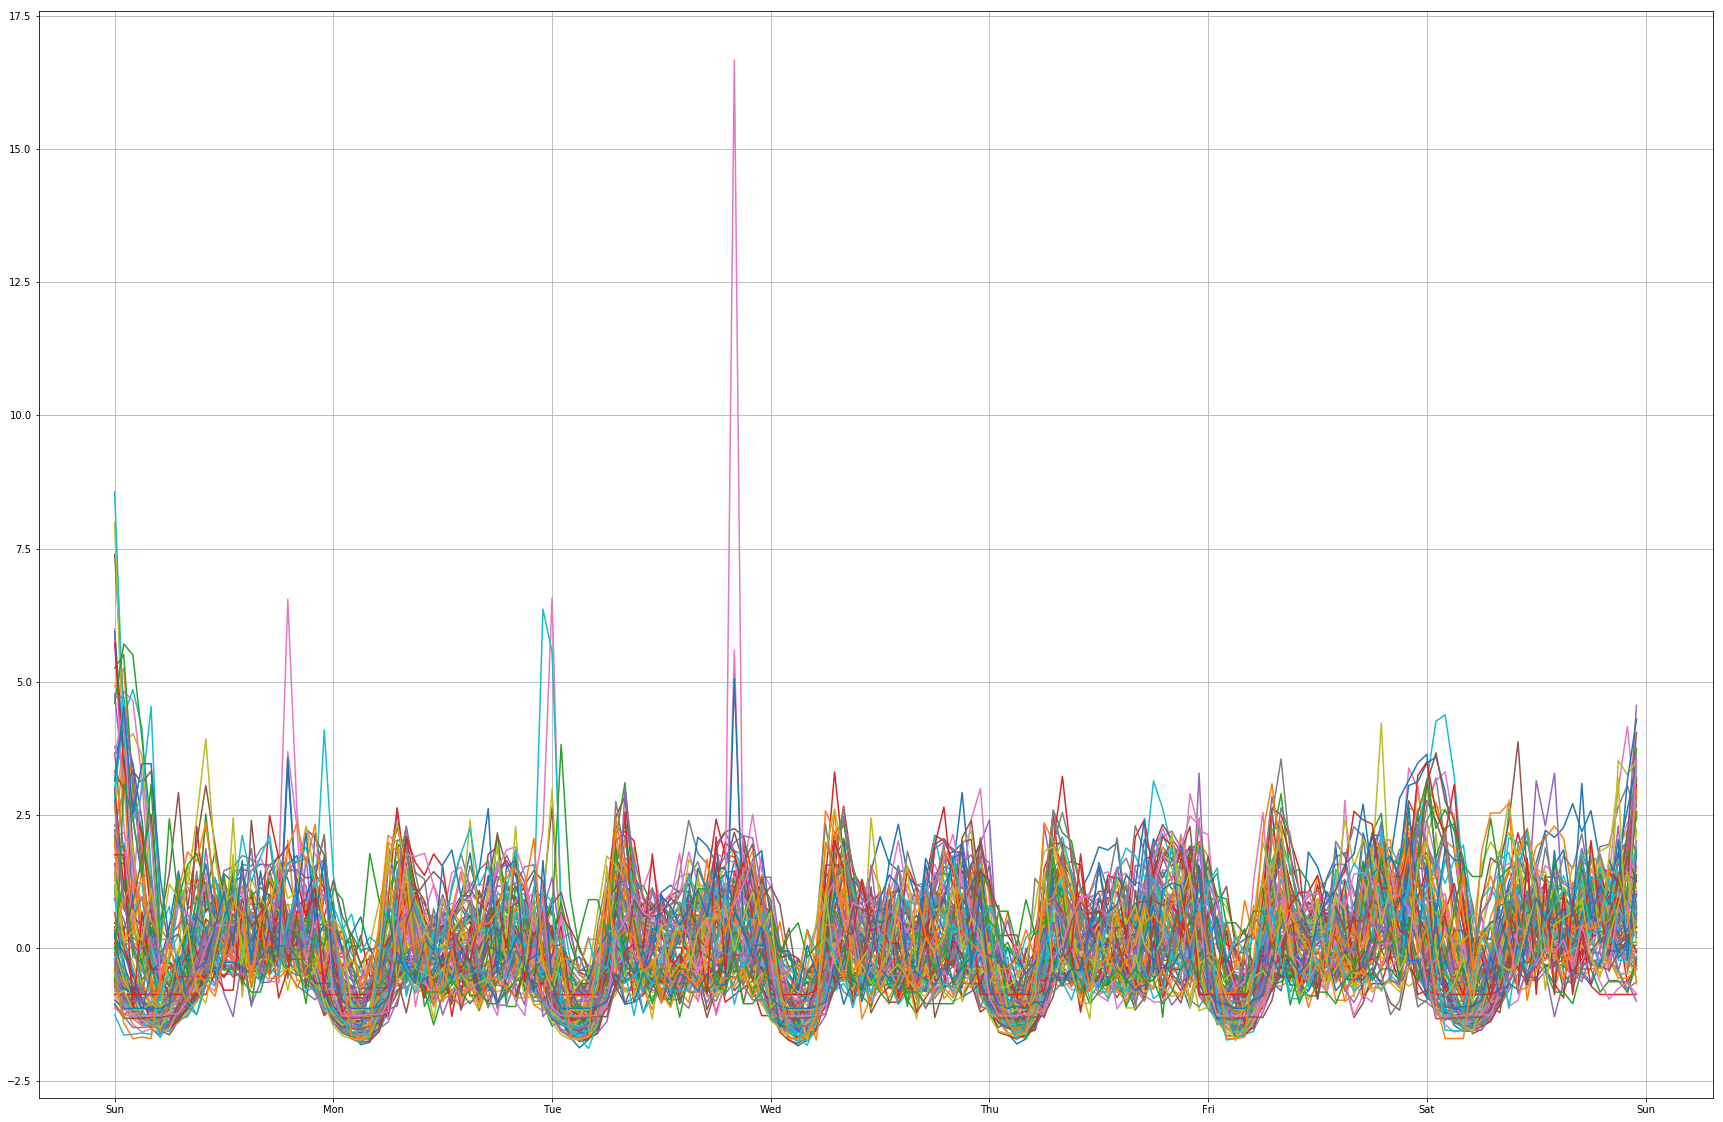

In [9]:
# сначала посмотрим, как выглядят стандартизованные ряды на примере 7 последних дней
figsize = (30,20)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(data_pivot_scaled.tail(24*7))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)

Судя по графику видно, у всех рядов явно выражен ночной спад поездок, встречаются выбросы, но в целом, визуально данные довольно хаотичны, и визуально кластеры выделить сложно.
Попробуем выделить кластеры с помощью разных методов и выберем из них наиболее подходящий.

1. Иерархическая кластеризация, linkage

In [10]:
def plot_series(series, clusters):
    clusterset = set(clusters.values())
    fig, axes = plt.subplots(
        nrows=math.ceil(len(clusterset)/2), 
        ncols=2, 
        figsize=(30, 30)
    )
    for i, clustername in enumerate(clusterset):
        r, c = math.floor(i/2), i%2
        axes[r, c].set_title('cluster {}'.format(clustername))
        axes[r, c].plot(
            series
            .tail(24*7)
            .loc[:, [key for key, value in clusters.items() if value==clustername]]
        )

In [11]:
def try_algorithm(algorithm, samples, series):
    model = algorithm.fit(samples)
    clusters = dict(
        zip(
            series.columns.values, 
            model.labels_
        )
    )
    plot_series(data_pivot_scaled, clusters)
    
    return model, clusters

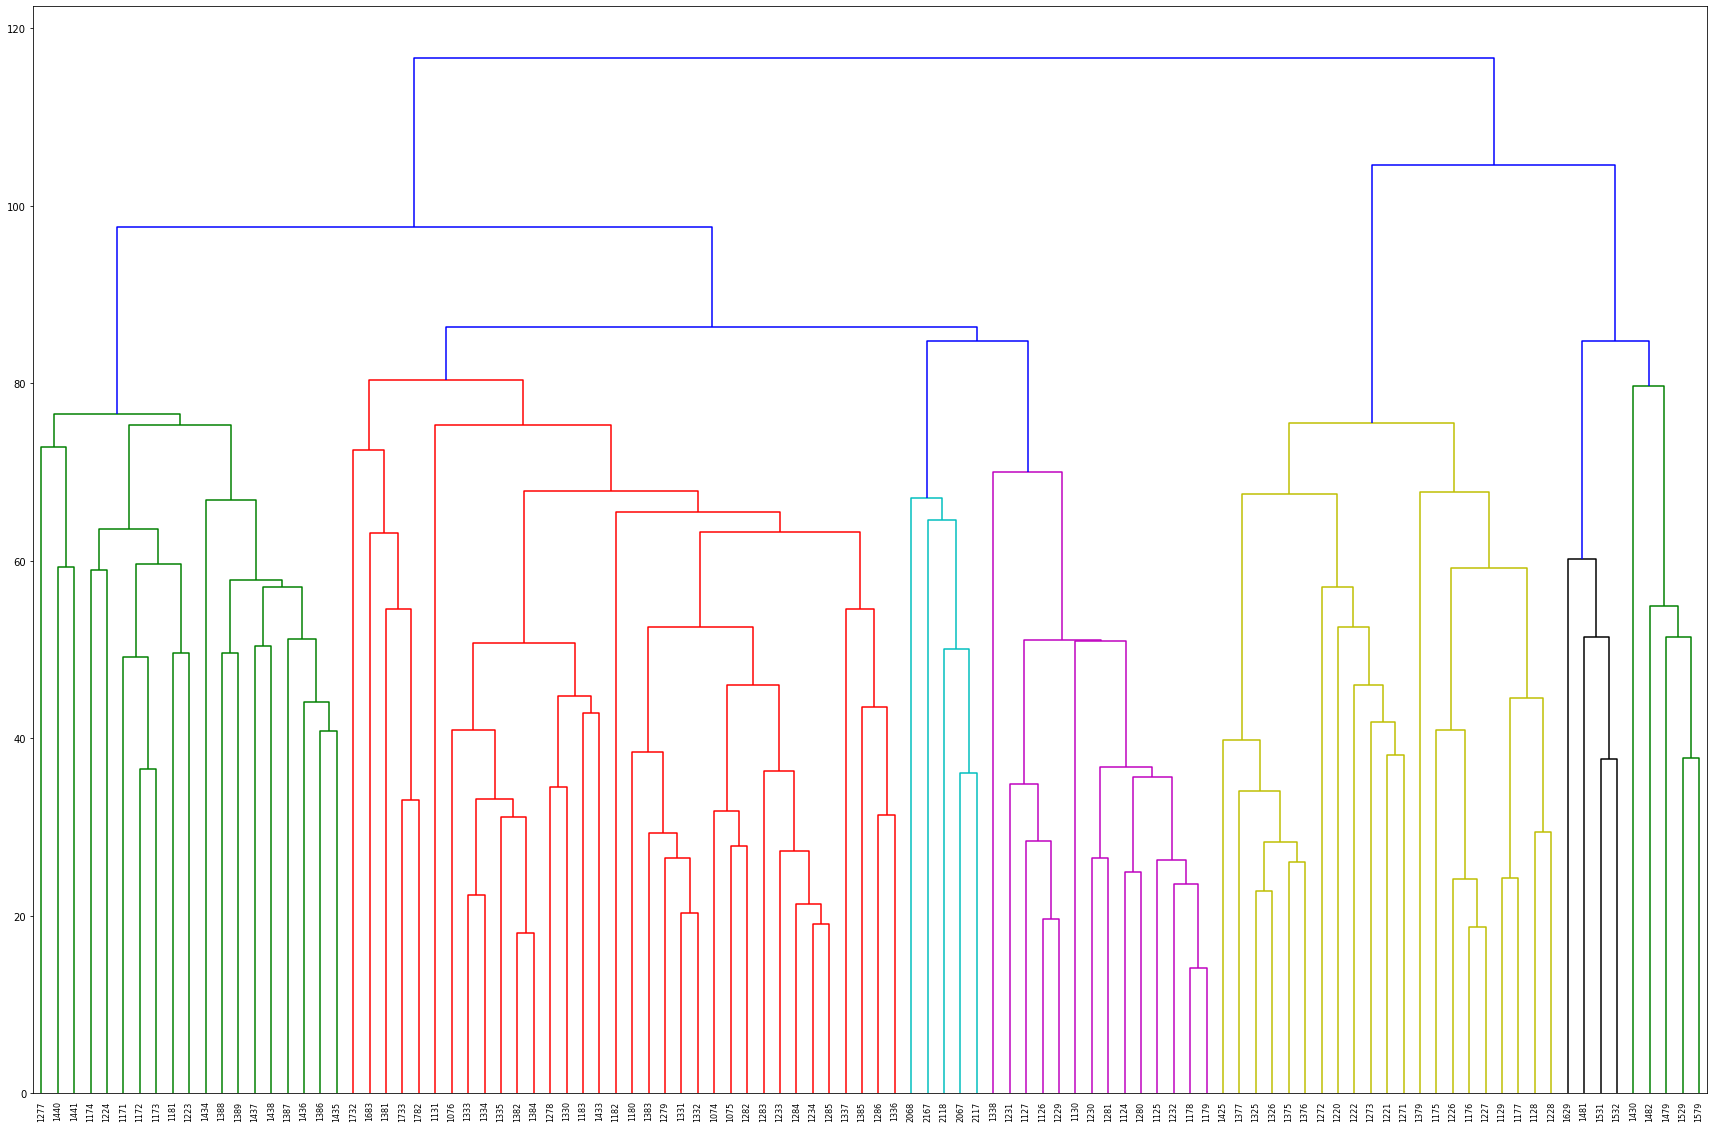

In [12]:
# Делаем из данных массив NumPy
samples = data_pivot_scaled.values.T

# Реализация иерархической кластеризации при помощи функции linkage
mergings = linkage(samples, method='complete')

# Строим дендрограмму
figsize = (30,20)
fig, ax = plt.subplots(figsize=figsize)
dh = dendrogram(mergings,
           labels=data_pivot_scaled.columns.values,
           leaf_rotation=90,
           leaf_font_size=8,
           ax=ax
           )

plt.show()

На дендрограмме выделяется 7 классов.
Отобразим их на графиках

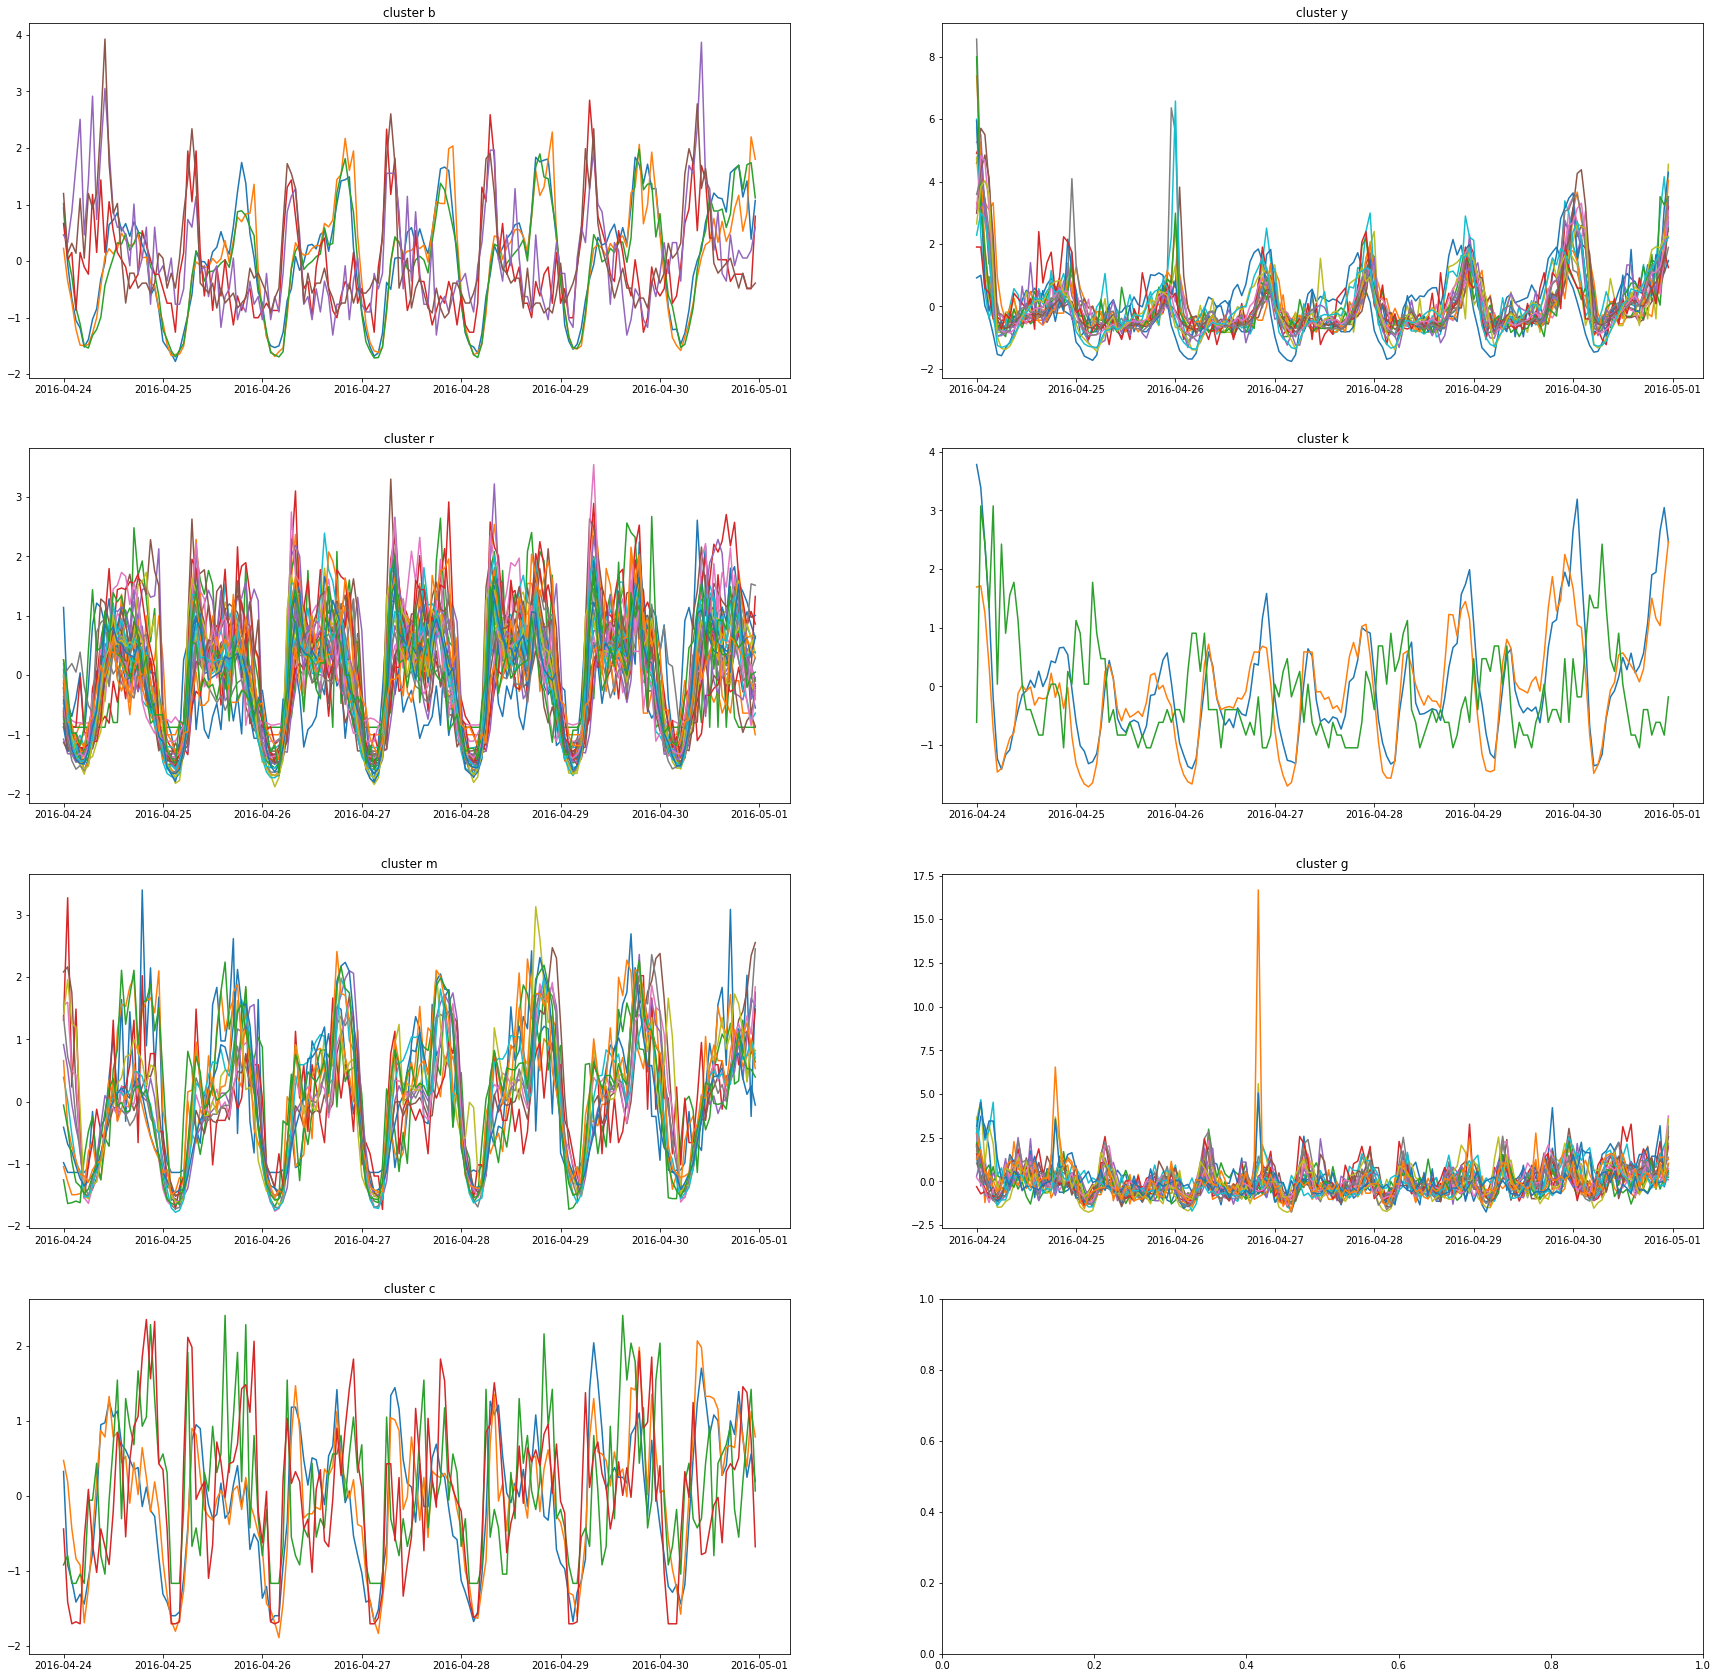

In [13]:
colors = dict(
    zip(
        dh.get('ivl'), 
        dh.get('color_list')
    )
)

plot_series(data_pivot_scaled, colors)

Результат довольно неоднозначный. Видно, что ряды в некоторых кластеры (b, k) сильно отличающиеся по своей структуре.

2. Агломеративная кластеризация

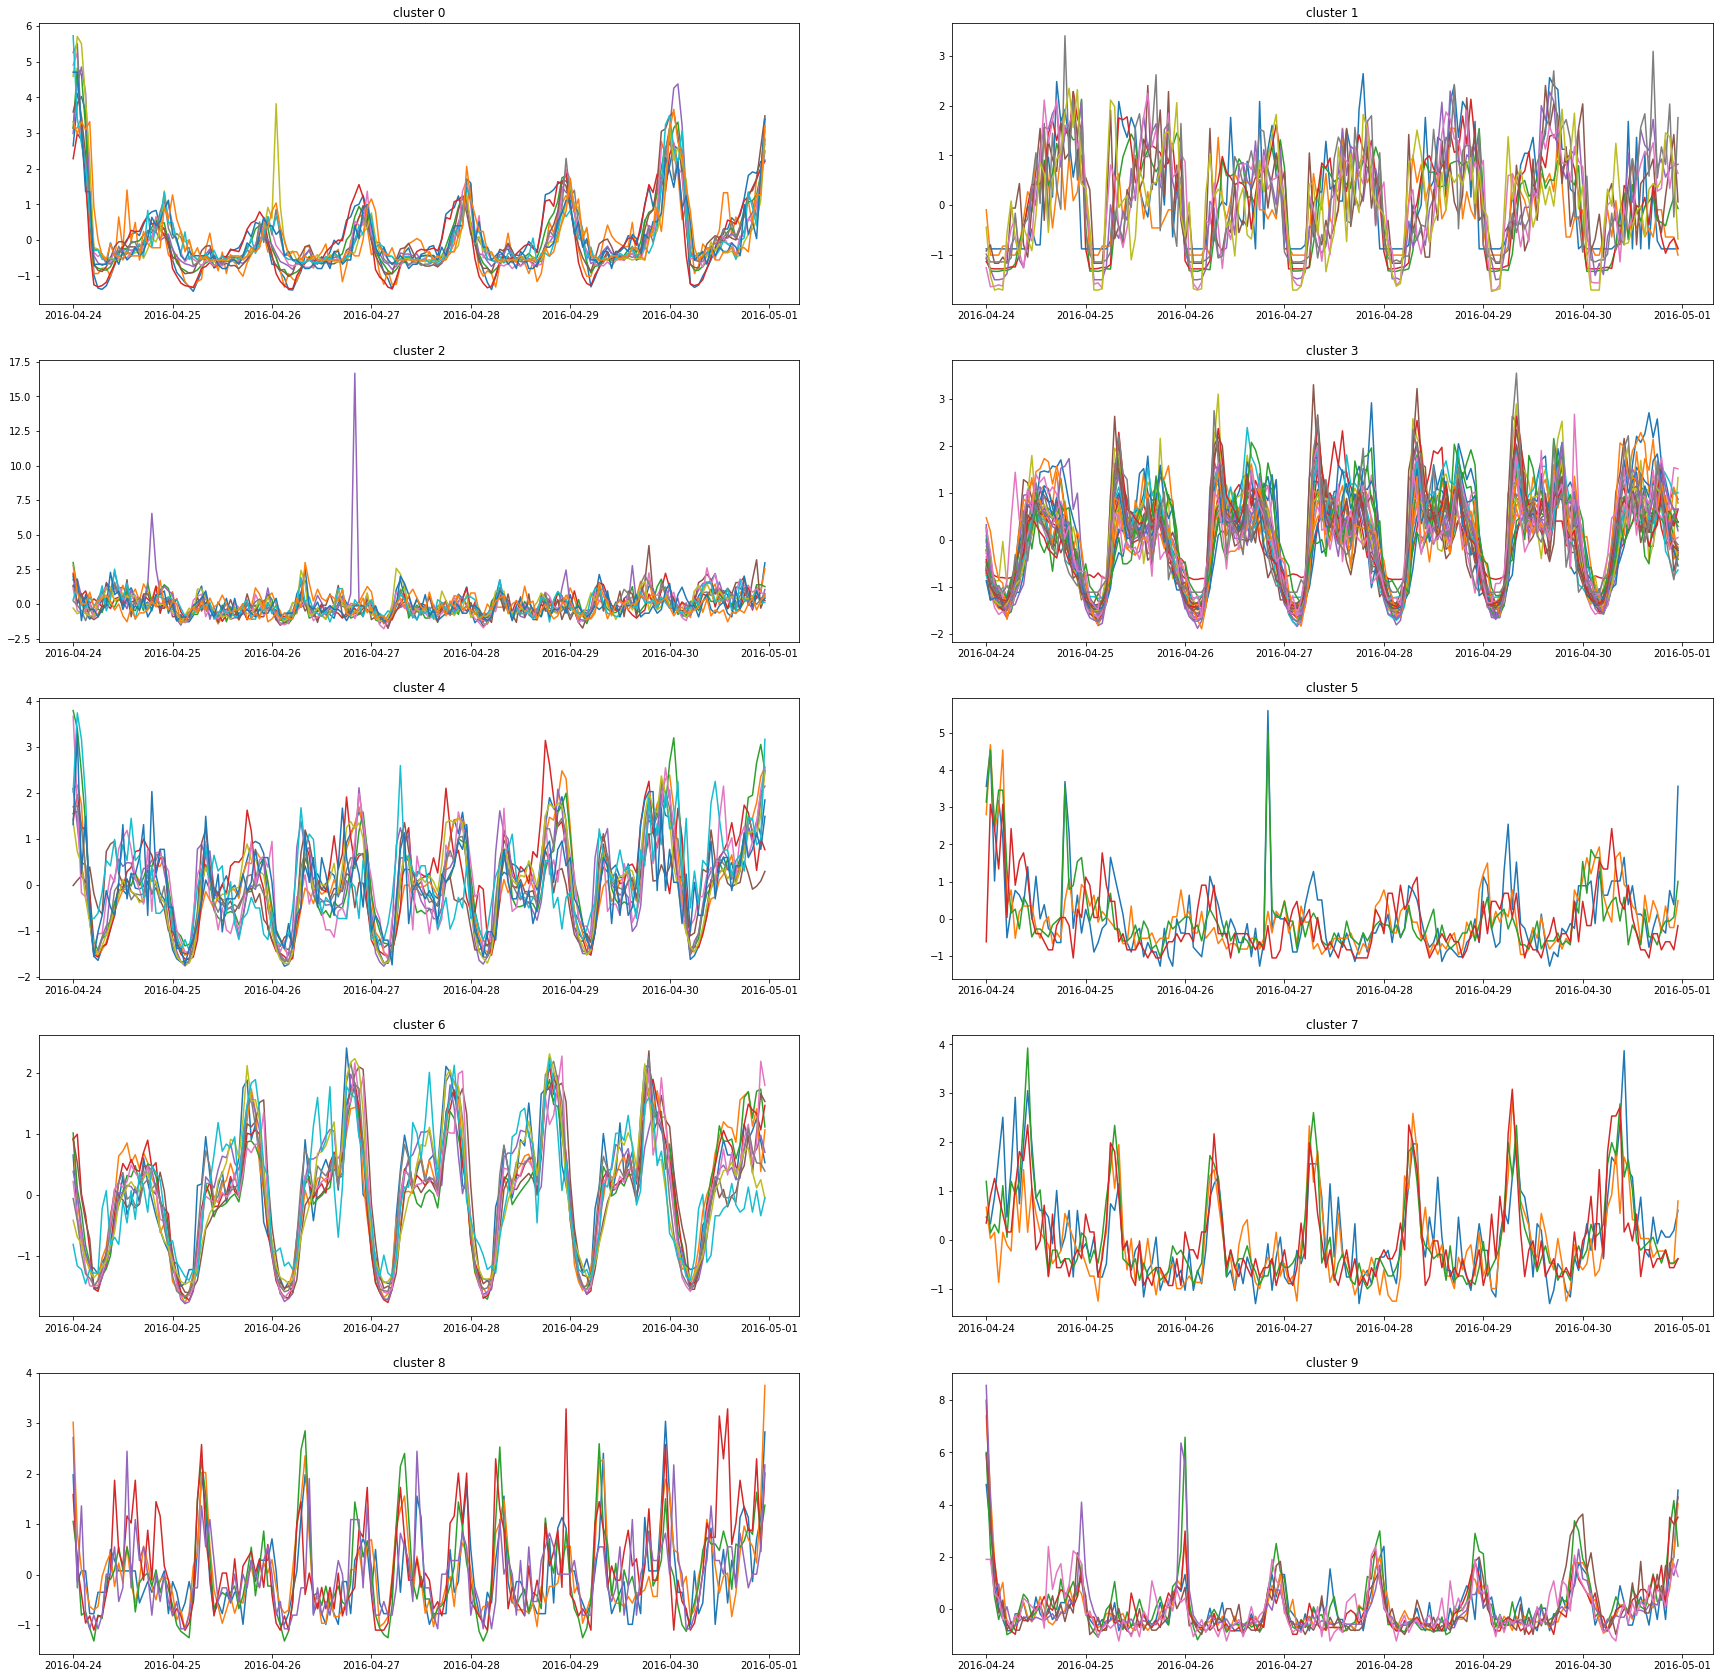

In [19]:
agg, region_clusters = try_algorithm(
    algorithm=cluster.AgglomerativeClustering(n_clusters=10),
    samples=samples, 
    series=data_pivot_scaled
)

Результат, в целом, неплохой, в кластеры попали графики со схожей формой. Однако, встречаются кластеры с довольно широкой дисперсией (1,3,4)

3. Спектральная кластеризация

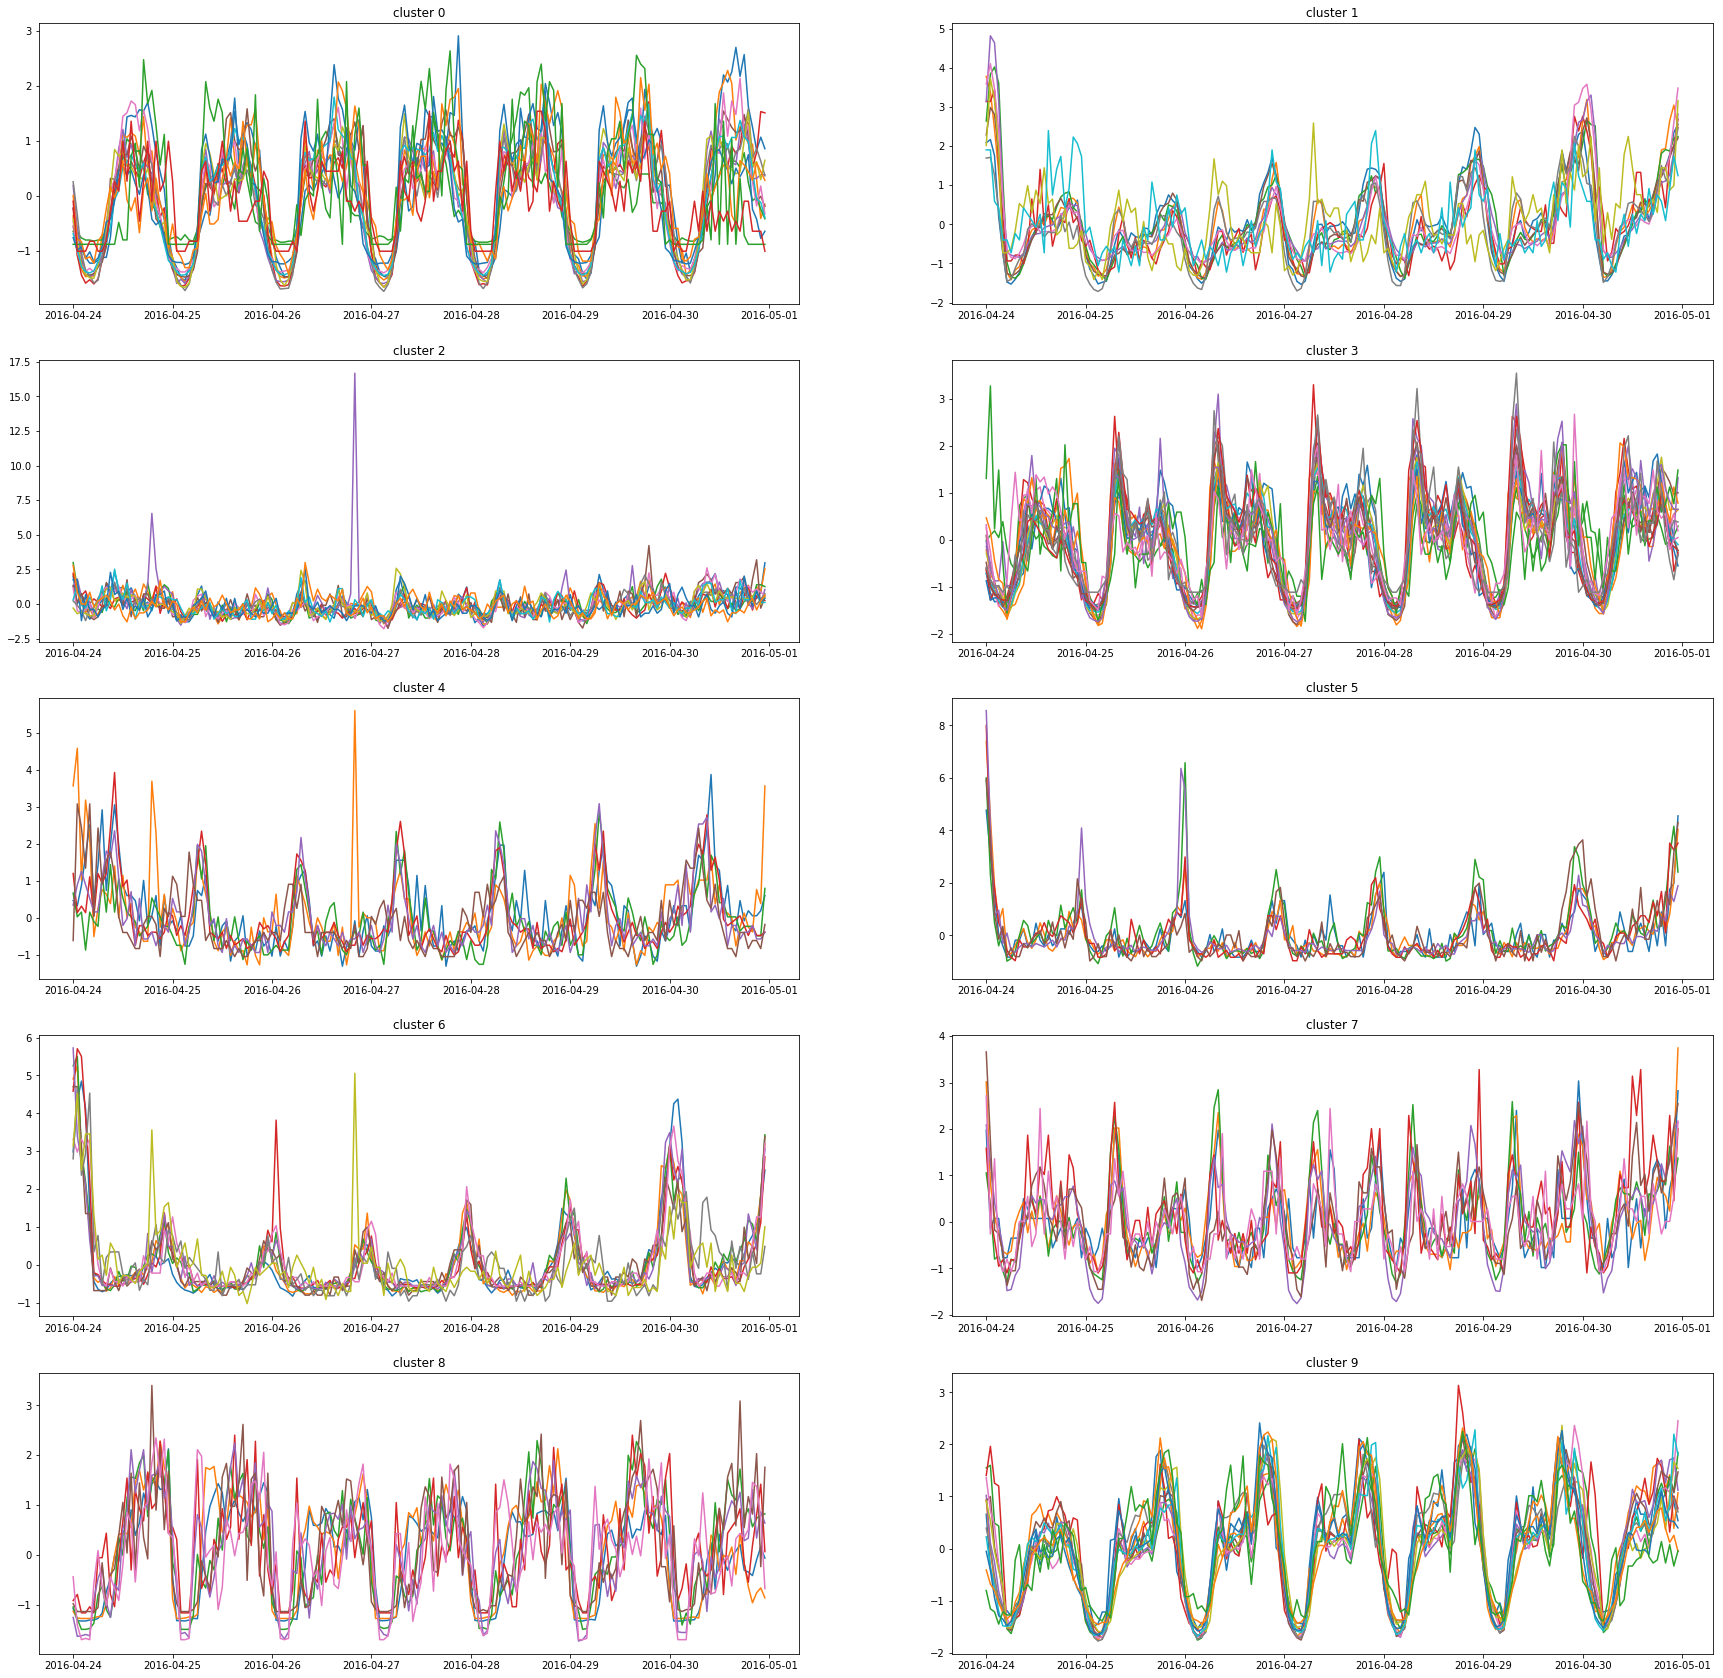

In [20]:
sp, region_clusters = try_algorithm(
    algorithm=cluster.SpectralClustering(
        n_clusters=10, 
        eigen_solver='arpack',
        affinity="nearest_neighbors"
    ),
    samples=samples, 
    series=data_pivot_scaled
)

В целом, результат не сильно отличается от агломеративной кластеризации.

4. K-Means

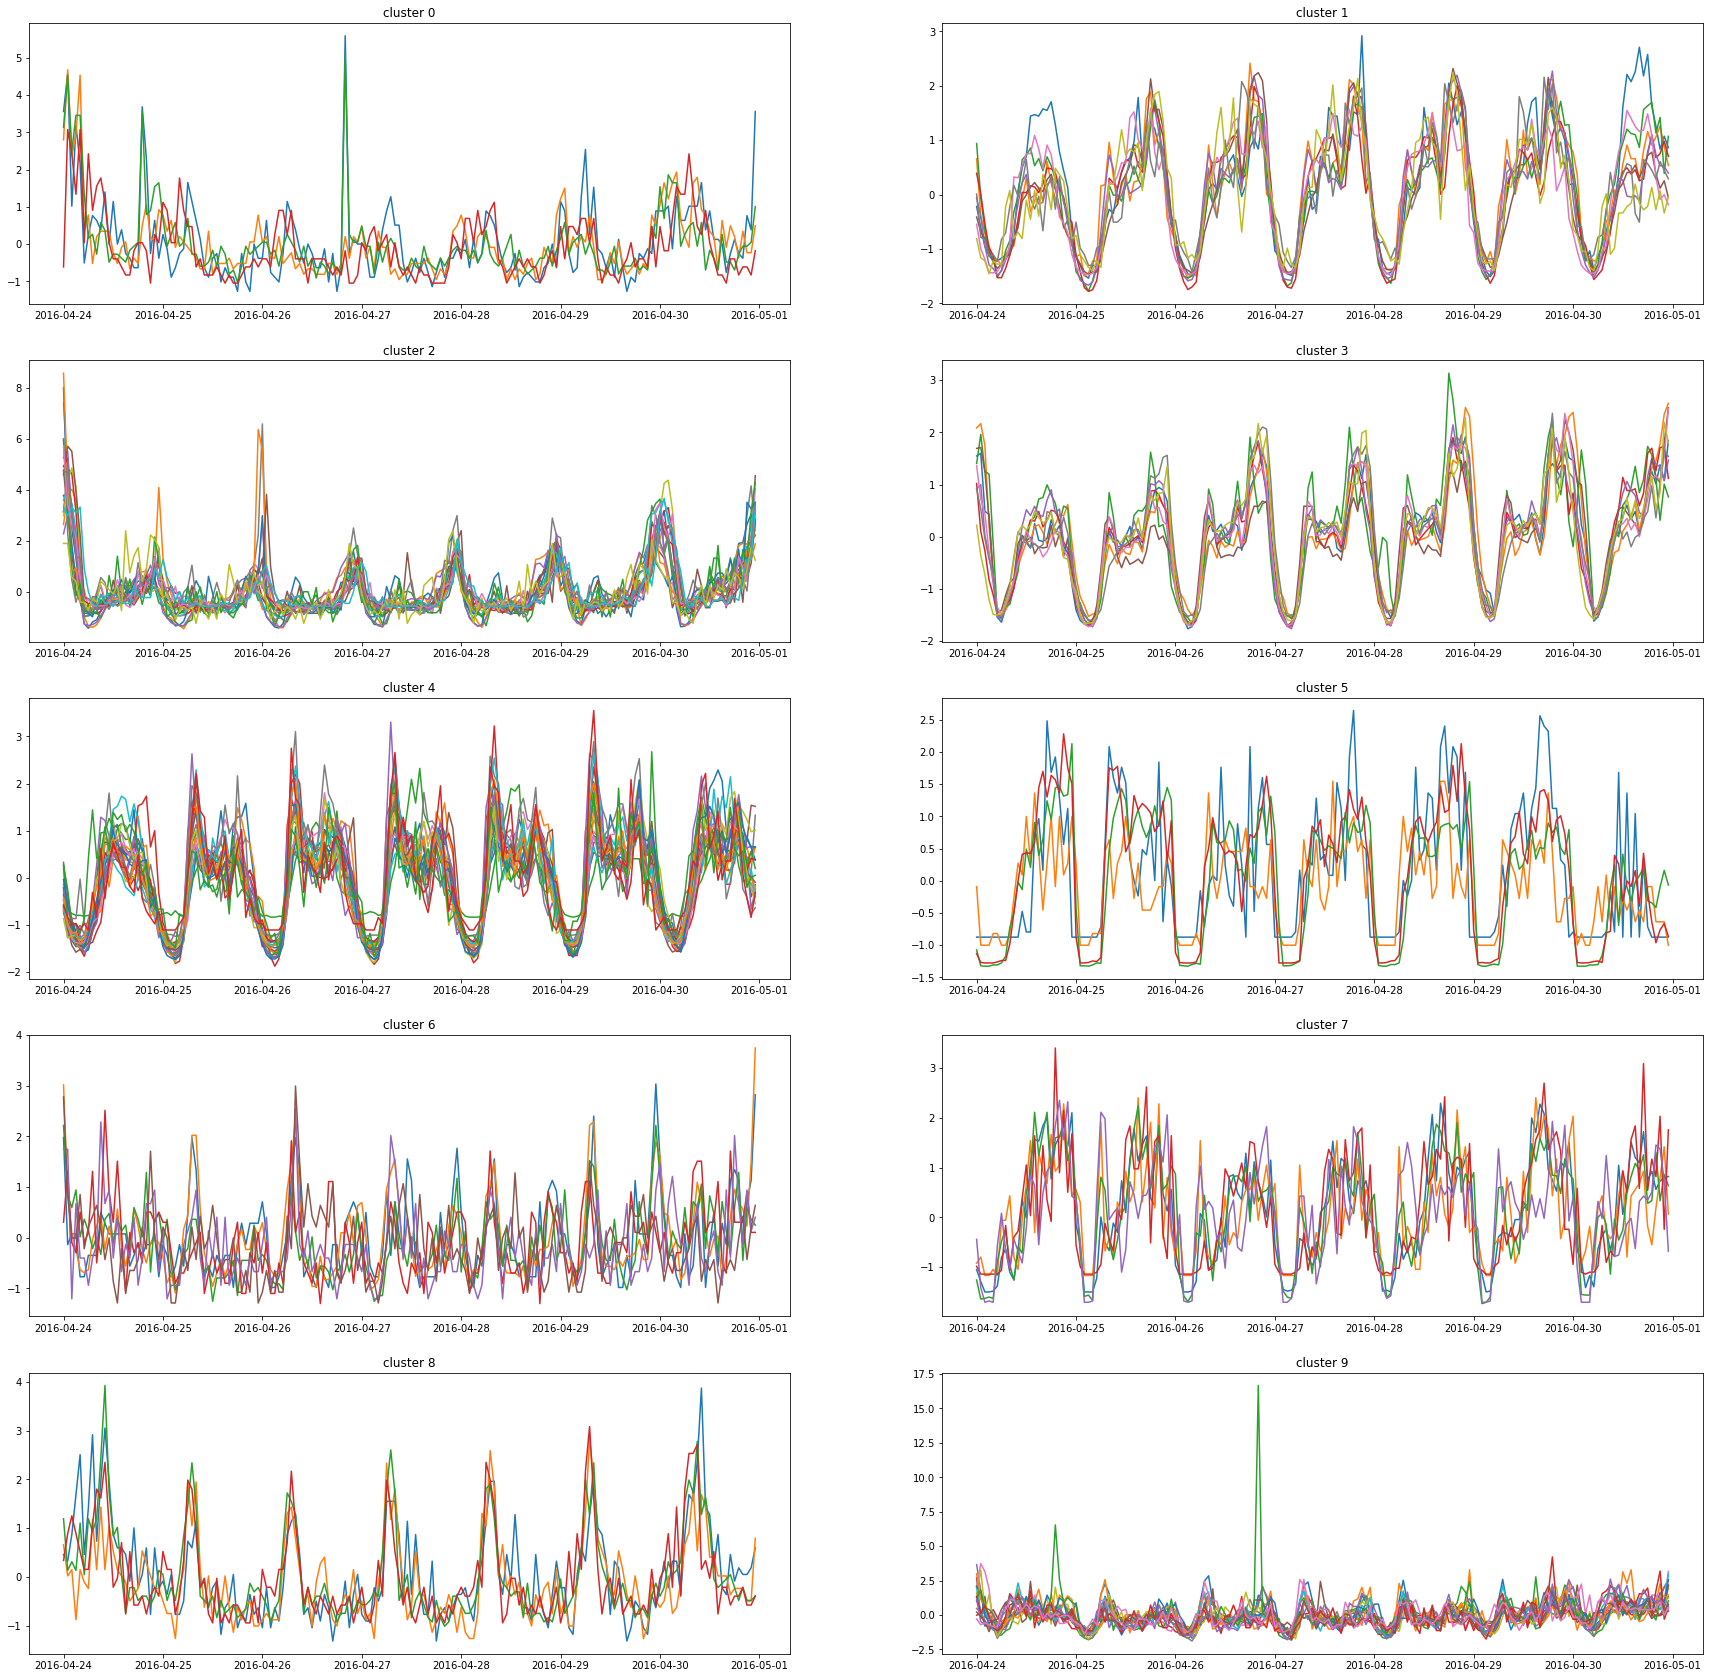

In [21]:
km, region_clusters = try_algorithm(
    algorithm=cluster.MiniBatchKMeans(
        n_clusters=10,
        batch_size=50
    ),
    samples=samples,
    series=data_pivot_scaled
)

Визуально, результат даже хуже, чем в случае агломеративной и спектральной кластеризации

5. Affinity Propagation

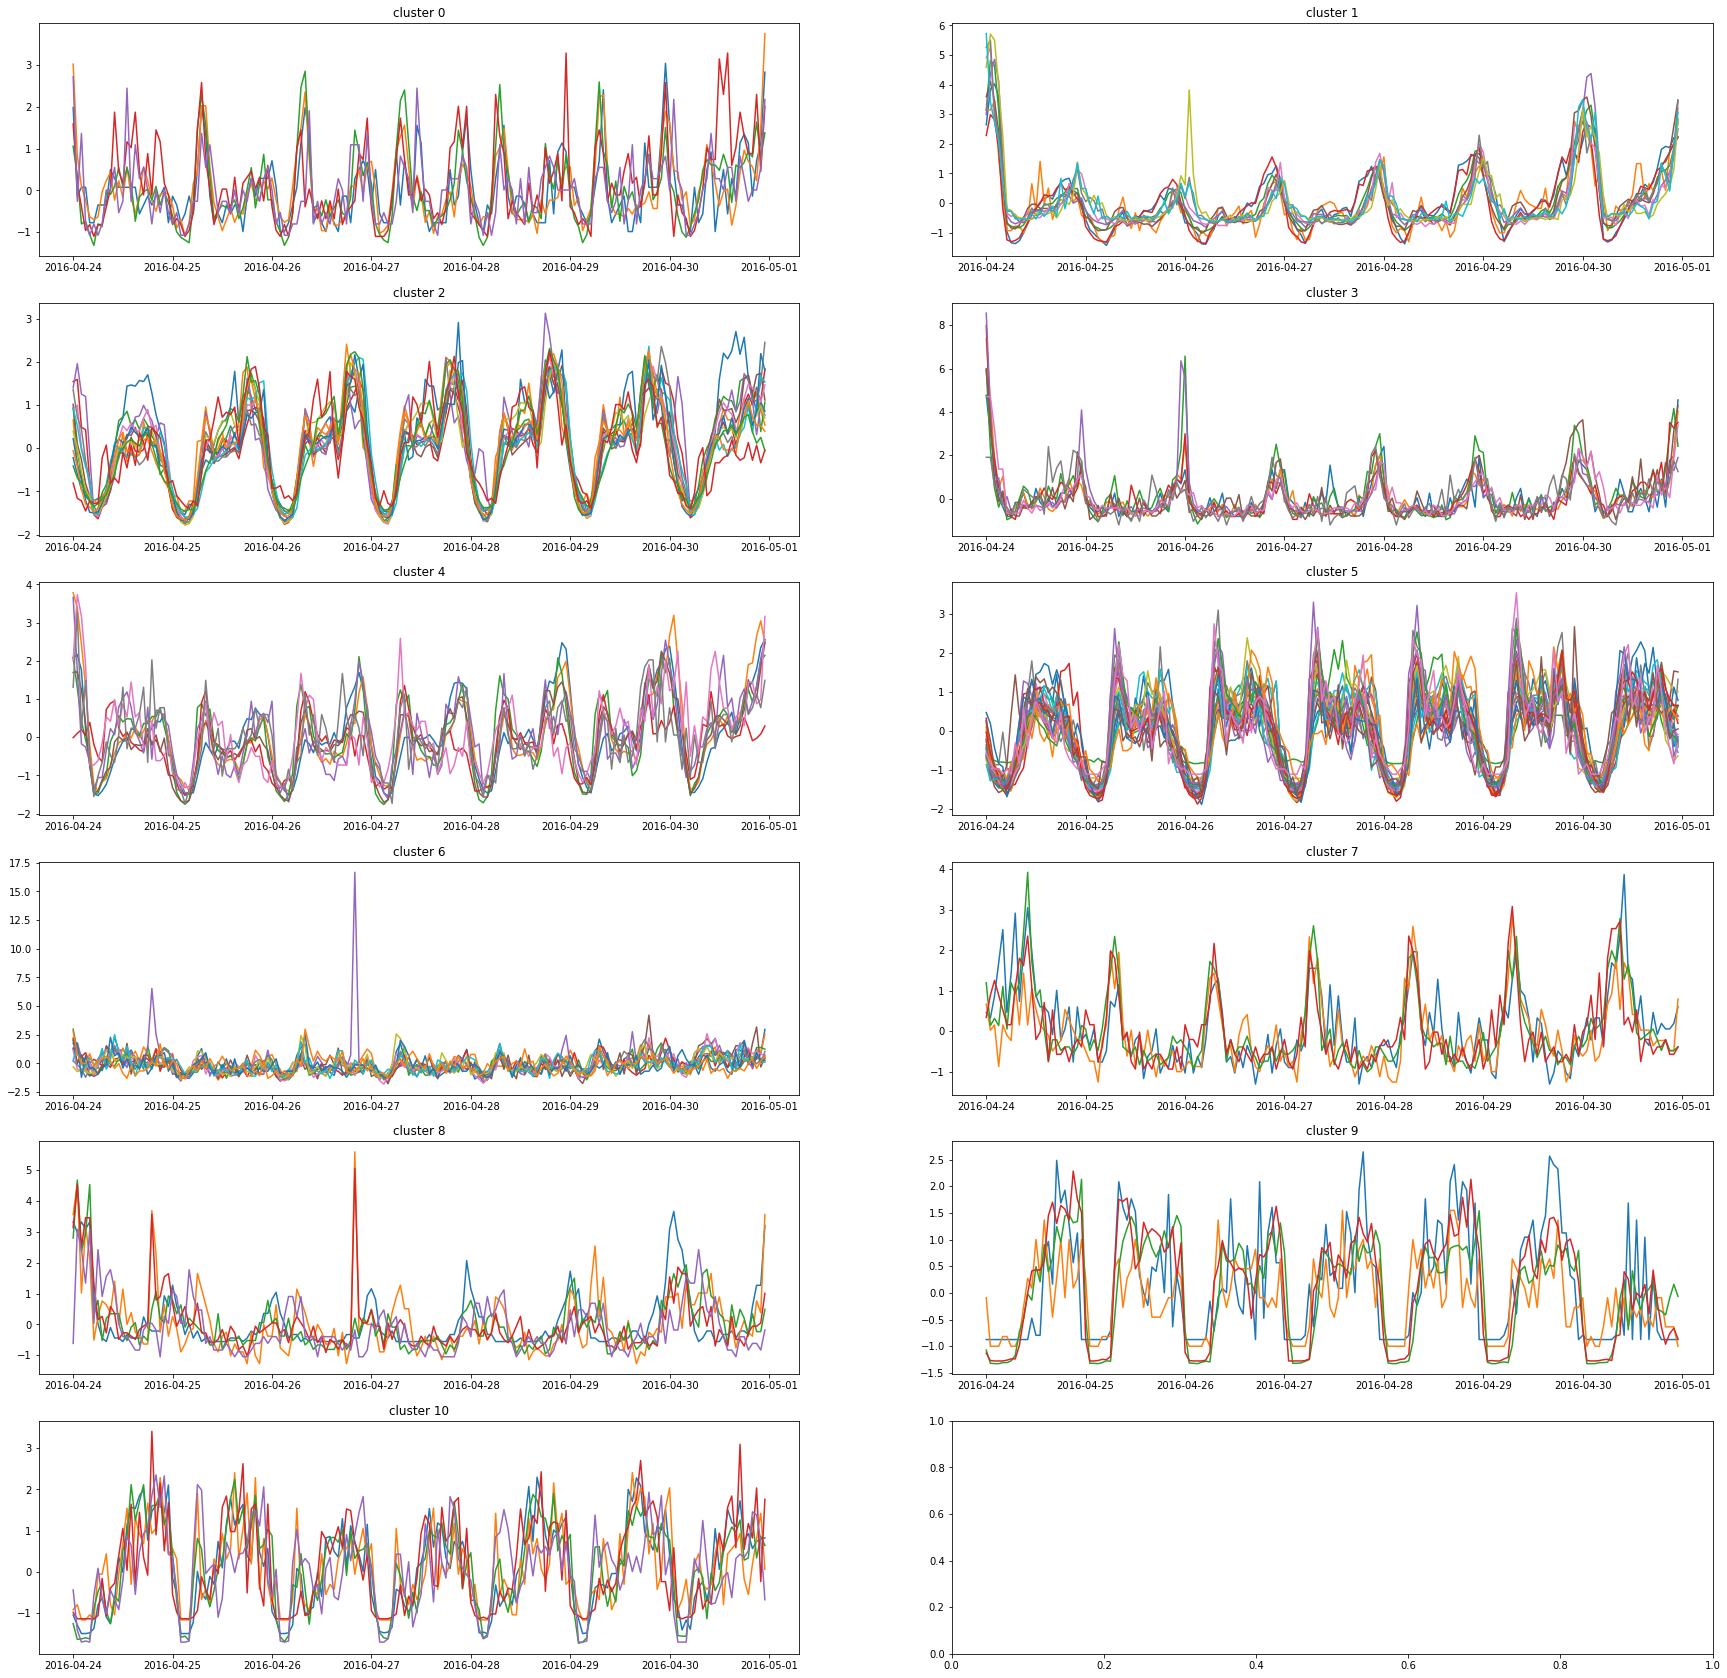

In [22]:
ap, region_clusters = try_algorithm(
    algorithm=cluster.AffinityPropagation(damping=0.7),
    samples=samples,
    series=data_pivot_scaled
)

Визуально, это наиболее приемлемый результат

#### 4.
В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

In [24]:
ap.cluster_centers_indices_

array([13, 16, 19, 25, 31, 55, 71, 88, 90, 96, 99], dtype=int64)

In [25]:
cluster_center_regions = data_pivot.columns[ap.cluster_centers_indices_]

#### 5.
Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [26]:
def harmonic(df, func, k, period):
    return df.apply(
        lambda x: func(
            df.index.get_loc(x.name)*2*math.pi*k/period
        ),
        axis=1
    )

In [27]:
# функция создания регрессионных признаков и сезонного/обычного дифференцирования
def calc_linreg(data, regions):
    data = data.loc[:, regions]
    
    # выходной день
    data.loc[:, 'week_isweekend'] = ((data.index.dayofweek)// 5 == 1).astype(float)
    
    # гармоники
    for k in (2,4,7,9,11,14):
        week_period=24*7
        data.loc[:, 'week_sin_{}'.format(k)] = harmonic(data, math.sin, k, week_period)
        data.loc[:, 'week_cos_{}'.format(k)] = harmonic(data, math.cos, k, week_period)
    
    regres_cols = [x for x in data.columns if x.startswith('week_')]
    
    for region in regions:
        
        # используем обычную линейную регрессию
        model = LinearRegression().fit(
            X=data.loc[:, regres_cols], 
            y=data.loc[:, region]
        )

        # посчитаем остатки
        data.loc[:, '{}_pred'.format(region)] = model.predict(data.loc[:, regres_cols])
        data.loc[:, '{}_resid'.format(region)] = data.loc[:, region] - data.loc[:, '{}_pred'.format(region)]
        
        resid_168 =  (data.loc[:, '{}_resid'.format(region)] - data.loc[:, '{}_resid'.format(region)].shift(24*7))
        data.loc[:, '{}_resid_168_1'.format(region)] = (resid_168 - resid_168.shift(1))
        
    return data

In [28]:
# графики ACF, PACF
def plot_graphs(data, regions):
    fig, axes = plt.subplots(
        2*regions.shape[0], 
        2, 
        figsize=(30, 15*regions.shape[0])
    )
    
    for i, region in enumerate(regions):
        series = data.loc[:, '{}_resid_168_1'.format(region)].dropna()
        ax_Q = axes[i*2, 0]
        ax_q = axes[i*2, 1]
        ax_P = axes[i*2 + 1, 0]
        ax_p = axes[i*2 + 1, 1]
        
        #acf
        x = sm.graphics.tsa.plot_acf(series, lags=24*7*3, ax=ax_Q)
        ax_Q.set_title('Q for region {}'.format(region))
        ax_Q.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
        ax_Q.xaxis.grid(True)
        
        x = sm.graphics.tsa.plot_acf(series, lags=24*4, ax=ax_q)
        ax_q.set_title('q for region {}'.format(region))
        ax_q.xaxis.set_major_locator(ticker.MultipleLocator(24))
        ax_q.xaxis.grid(True)
        
        #pacf
        x = sm.graphics.tsa.plot_pacf(series, lags=24*7*7, ax=ax_P)
        ax_P.set_title('P for region {}'.format(region))
        ax_P.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
        ax_P.xaxis.grid(True)
        
        x = sm.graphics.tsa.plot_acf(series, lags=24*4, ax=ax_p)
        ax_p.set_title('p for region {}'.format(region))
        ax_p.xaxis.set_major_locator(ticker.MultipleLocator(24))
        ax_p.xaxis.grid(True)

C:\Users\Dmitry\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


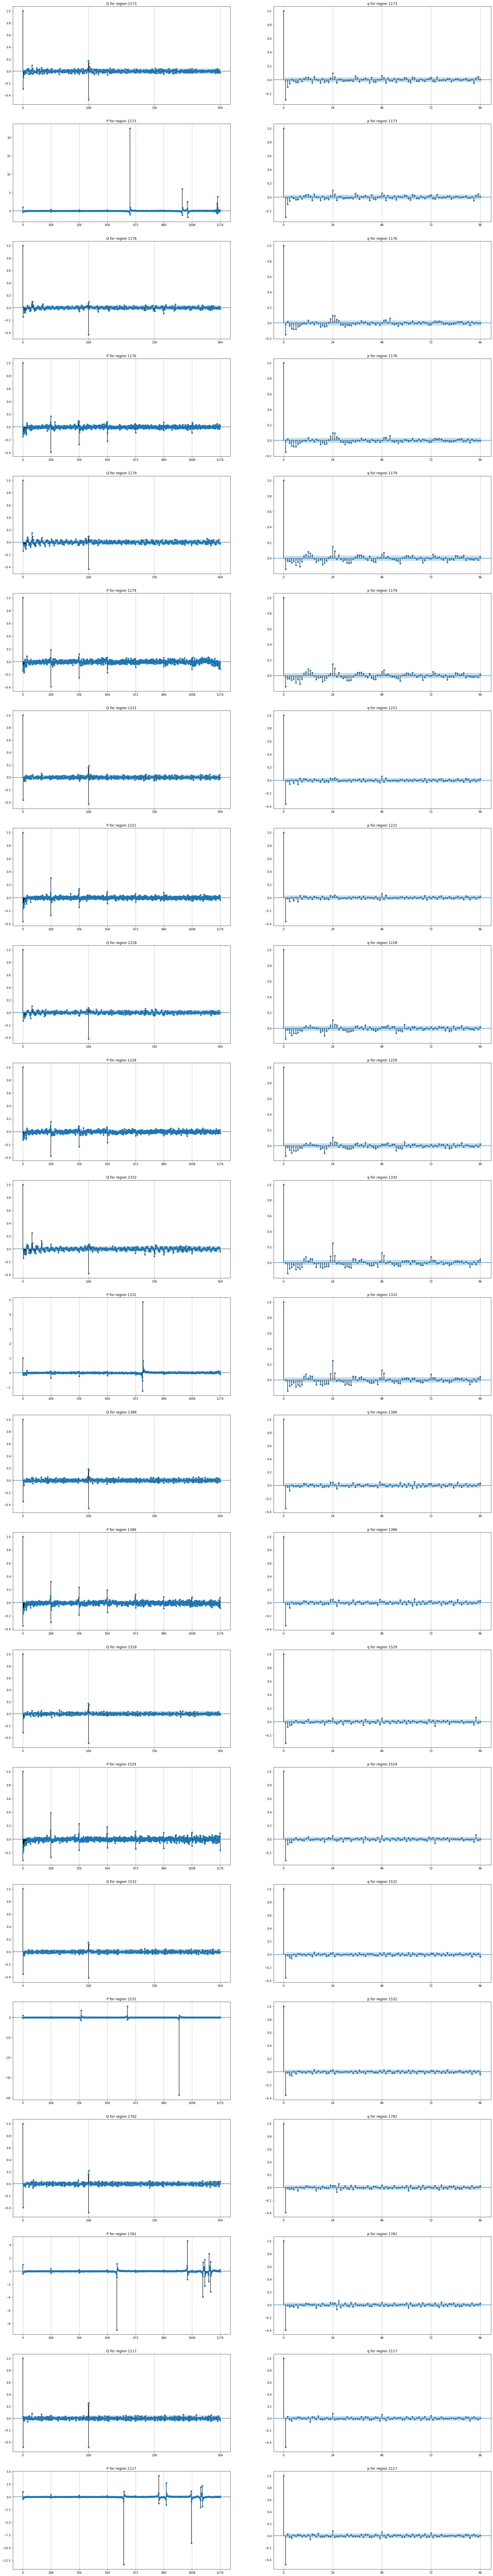

In [31]:
# подберем начальные приближения P, p, Q, q для каждого ряда
data_pivot_linreg = calc_linreg(data_pivot, regions)
plot_graphs(data_pivot_linreg, regions)

In [34]:
# начальные приближения p, q, P, Q
params = {
    '1173': [3,3,2,1],
    '1176': [1,1,4,1],
    '1179': [9,9,4,1],
    '1221': [1,1,4,1],
    '1228': [1,1,4,1],
    '1332': [1,1,3,2],
    '1386': [1,1,5,1],
    '1529': [4,4,7,1],
    '1532': [1,1,1,1],
    '1782': [1,1,2,1],
    '2117': [1,1,2,1]
}

#### 6.
Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза

In [36]:
# класс для подбора оптимальных по aic параметров
# значительно сокращает число переборов
class ParamGenerator():
    def __init__(self, p, q, P, Q, order=[0,1,2,3]):
        self.max_params = [p,q,P,Q]
        self.current_params = [0,0,0,0]
        self.best_params = [0,0,0,0]
        self.order_index = 0
        self.max_index = 3
        self.best_aic = float("inf")
        self.base_aic = float("inf")
        self.completed = False
        self.order=order
        self.step=0
        
    def get_index(self):
        return self.order[self.order_index]
    
    def get_params(self, last_aic):
        
        # значения параметров, текущее и максимальное
        current_value = self.current_params[self.get_index()]
        max_value = self.max_params[self.get_index()]
        
        # сохранение оптимального по aic значения параметра
        if last_aic < self.best_aic:
            self.best_aic = last_aic
            self.best_params[self.get_index()] = self.current_params[self.get_index()]
        
        # инициализация - в качестве baseline принимается aic при стартовых значениях параметров
        if self.step == 0 and last_aic != float("inf"):
            self.base_aic = last_aic
            self.step = 1
        
        # перебираются возможные значения каждого параметра, при этом остальные параметры фиксируются в 0
        elif self.step == 1:
            if self.order_index == self.max_index and current_value == max_value:
                self.step = 2
                self.current_params = self.best_params[:]
                self.order_index = 0
                self.best_aic = self.base_aic
            
            else:
                if current_value == max_value:
                    self.current_params[self.get_index()] = 0
                    self.order_index += 1
                    self.best_aic = self.base_aic
                
                self.current_params[self.get_index()] += 1
        
        # каждый по очереди параметр уменьшается на 1, и проверяется aic модели
        elif self.step == 2:
            switch_index = (current_value == 0 or last_aic > self.best_aic)
            
            if self.order_index == self.max_index and switch_index:
                self.completed = True
                
            else:
                if switch_index:
                    self.current_params[self.get_index()] = self.best_params[self.get_index()]
                    self.order_index += 1
                
                self.current_params[self.get_index()] -= 1    
        
        return self.current_params

# обертка для sarimax
def get_sarimax(endog, order, seasonal_order, **kwargs):
    return sm.tsa.statespace.SARIMAX(
        endog=endog,
        order=order,
        seasonal_order=seasonal_order,
        initialization='approximate_diffuse',
        low_memory=True,
        **kwargs
    )

# расчет sarimax
def calc_sarimax(data, order, seasonal_order, return_model=False, **kwargs):
    model = get_sarimax(data, order, seasonal_order, **kwargs).fit(disp=-1)
    if return_model:
        return model
    else:
        return model.aic

# перебор параметров
def test_params(data, p, q, P, Q, D, d, s, exog=None):
    aic = float("inf")
    max_loop_count = (p+q+P+Q)*2
    params = ParamGenerator(p, q, P, Q)

    try:
        warnings.filterwarnings('ignore')
        for i in range(1, max_loop_count + 1):

            param = params.get_params(aic)
            if params.completed:
                break

            try:
                print('{}/{}: {}'.format(i, max_loop_count, param))
                aic=calc_sarimax(
                    data,
                    exog=exog,
                    order=(param[0], d, param[1]),
                    seasonal_order=(param[2], D, param[3], s),
                )
                print(aic)

            except ValueError:
                continue

    finally:
        warnings.filterwarnings('default')
    
    return params.best_params

In [43]:
%%time
# подбор оптимальных параметров моделей
# exog использовать не будем для ускорения подбора параметров, будем считать на остатках от линейной регрессии
D = 1
d = 1
s = 24 # период 24 часа

for region in params:
    print('Calculating region {}'.format(region))
    param = params.get(region)
    params[region] = test_params(
        data_pivot_linreg.loc[:, '{}_resid'.format(region)],
        *param, 
        D, d, s
    )

Calculating region 1173
1/18: [0, 0, 0, 0]
34492.78132500574
2/18: [0, 0, 0, 0]
34492.78132500574
3/18: [1, 0, 0, 0]
34416.2510766453
4/18: [2, 0, 0, 0]
34348.204892244314
5/18: [3, 0, 0, 0]
34200.64178769429
6/18: [0, 1, 0, 0]
34382.93221371319
7/18: [0, 2, 0, 0]
33766.13394835942
8/18: [0, 3, 0, 0]
33404.01649061643
9/18: [0, 0, 1, 0]
34088.600343438506
10/18: [0, 0, 2, 0]
33980.079050677086
11/18: [0, 0, 0, 1]
32617.88230124857
12/18: [3, 3, 2, 1]
31553.84202934669
13/18: [2, 3, 2, 1]
31578.42356841033
14/18: [3, 2, 2, 1]
31579.29666211508
15/18: [3, 3, 1, 1]
31427.744824834775
16/18: [3, 3, 0, 1]
31486.12040693897
17/18: [3, 3, 1, 0]
32930.52864125847
Calculating region 1176
1/14: [0, 0, 0, 0]
52807.69421519039
2/14: [0, 0, 0, 0]
52807.69421519039
3/14: [1, 0, 0, 0]
52441.65963459792
4/14: [0, 1, 0, 0]
52509.85507895713
5/14: [0, 0, 1, 0]
52616.93605188526
6/14: [0, 0, 2, 0]
52281.78504178562
7/14: [0, 0, 3, 0]
52203.20768044192
8/14: [0, 0, 4, 0]
52053.34240664101
9/14: [0, 0, 0, 

In [44]:
# оптимальные значения параметров
params

{'1173': [3, 3, 1, 1],
 '1176': [1, 1, 4, 1],
 '1179': [8, 9, 1, 1],
 '1221': [1, 1, 2, 1],
 '1228': [1, 1, 3, 1],
 '1332': [1, 1, 2, 2],
 '1386': [1, 1, 3, 1],
 '1529': [0, 4, 0, 1],
 '1532': [1, 1, 1, 1],
 '1782': [1, 1, 2, 1],
 '2117': [0, 1, 2, 1]}

In [45]:
# класс для хранения параметров модели
class SarimaxParams:
    def __init__(self, order_params, model_params):
        self.order_params = order_params
        self.model_params = model_params

In [46]:
%%time
# расчет остатков линейной регрессии по всем зонам
data_pivot_linreg_all = calc_linreg(data_pivot_all, data_pivot_all.columns)

Wall time: 4.29 s


In [47]:
# обучение моделей и сохранение параметров
def fit_models(df, region_clusters, params):
    cluster_models = {}
    
    try:
        warnings.filterwarnings('ignore')

        for region in params:
            param = params.get(region)
            cluster_id = region_clusters.get(region)
            order_params = {
                'order': (param[0], d, param[1]),
                'seasonal_order': (param[2], D, param[3], s)
            }

            cluster_models[cluster_id] = SarimaxParams(
                order_params,
                calc_sarimax(
                    df.loc[:'2016-04-30', '{}_resid'.format(region)],
                    return_model=True,
                    **order_params
                ).params
            )

    finally:
        warnings.filterwarnings('default')
    
    return cluster_models

In [48]:
%%time
cluster_models = fit_models(
    df=data_pivot_linreg_all,
    region_clusters=region_clusters,
    params=params
)

Wall time: 37min 20s


In [49]:
# фукнция расчета значения ошибки на текущем прогнозе
def calc_error(df, data_pred, time_index, period, region):
    data_true = df.iloc[time_index+1:time_index+period+1].loc[:, '{}'.format(region)]
    return abs(data_true - data_pred).sum()

In [50]:
# предсказания по всем зонам
def calc_prediction(df, region_clusters, cluster_models, start_date, finish_date, period, func):
    res = []
    
    start_index = df.index.get_loc(start_date)
    finish_index = df.index.get_loc(finish_date)
    
    for region in region_clusters:

        cluster_model = cluster_models.get(
            region_clusters.get(region)
        )
        
        model_fitted = get_sarimax(
            df.loc[:, '{}_resid'.format(region)],
            **cluster_model.order_params
        ).filter(cluster_model.model_params)
        
        for time_index in range(start_index, finish_index+1):
            data_pred = (
                model_fitted.predict(time_index+1, time_index+period, dynamic=True) 
                + df.iloc[time_index+1:time_index+period+1].loc[:, '{}_pred'.format(region)]
            )
            res.append(
                func(df, data_pred, time_index, period, region)
            )
    
    return res     

In [51]:
%%time
errors = calc_prediction(
    df=data_pivot_linreg_all,
    region_clusters=region_clusters,
    cluster_models=cluster_models,
    start_date='2016-04-30 23:00',
    finish_date='2016-05-31 17:00',
    period=6,
    func=calc_error 
)

Wall time: 25min 29s


In [52]:
print('Средняя абсолютная ошибка: {}'.format(sum(errors)/(102*729*6)))

Средняя абсолютная ошибка: 32.078336249808935


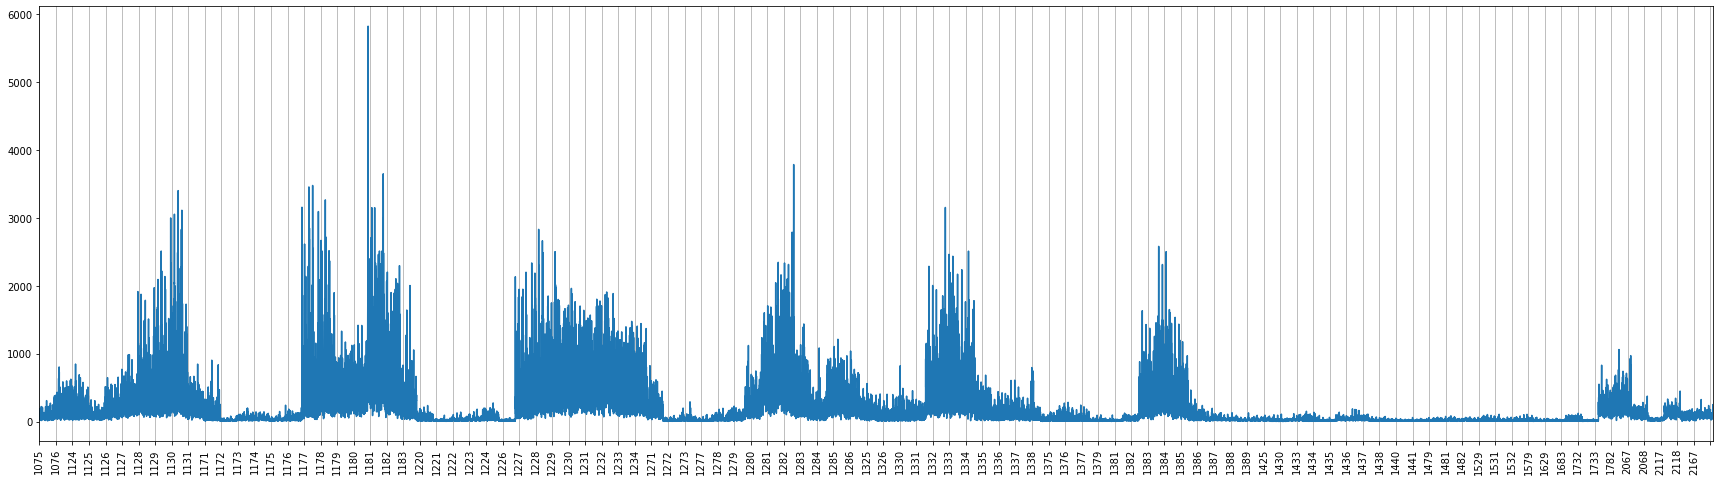

In [53]:
# график ошибок по зонам
fig, ax = plt.subplots(figsize=(30,8))
ax.set_xlim(0, len(errors))
ax.set_xticklabels(region_clusters.keys())
ax.xaxis.set_major_locator(ticker.MultipleLocator(745))
ax.xaxis.grid(True, which='major')
ax.xaxis.set_tick_params(rotation=90)
ax.plot(errors)

Видно, что в некоторых зонах ошибка слишком большая. Это значит, что данные зоны плохо моделируются рядом, который соответствует центру кластера, либо прогнозируемые данные сильно зашумлены

#### 7.
Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [56]:
# функция формирования прогноза в заданном формате
def prediction_format(df, data_pred, time_index, period, region):
    res = ''
    date = df.index[time_index]
    for pos, value in enumerate(data_pred.to_list()):
        res += '{region}_{:%Y-%m-%d}_{hour}_{ref},{pred}\n'.format(
            date,
            hour=date.hour,
            region=region,
            ref=pos+1,
            pred=value
        )
    
    return res

In [57]:
predictions = calc_prediction(
    df=data_pivot_linreg_all,
    region_clusters=region_clusters,
    cluster_models=cluster_models,
    start_date='2016-05-31 23:00',
    finish_date='2016-06-30 17:00',
    period=6,
    func=prediction_format 
)

In [58]:
# проверим получившийся размер массива. Должно получиться 102*715=72930, т.к. прогноз на 6 часов склеивался в 1 строку
len(predictions)

72930

In [68]:
# сохраним результат в csv
with open('june_predict.csv', "w") as csv:
    csv.write('id,y\n')
    csv.write(''.join(predictions))

#### 8.
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

Ссылка: https://www.kaggle.com/submissions/15144748/15144748.raw

Score: 29.71320